<a href="https://colab.research.google.com/github/cap497/SentimentWalk/blob/main/SentimentWalk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# %% [code]
# 1) Imports, seed e device
import os, json, time, math, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
from sentence_transformers import SentenceTransformer

plt.rcParams["figure.figsize"] = (12,8)
np.random.seed(42); random.seed(42)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🧠 Device: {DEVICE}")


🧠 Device: cuda


In [ ]:
# %% [code]
# 2) Loader para JSONL -> DataFrame (conversation_id, message_index, role, text)
def _get_role(msg):
    r = (msg.get("role") or msg.get("actor") or "").lower()
    if "user" in r: return "user"
    if "assistant" in r: return "assistant"
    if "system" in r: return "system"
    return r if r else "other"

def _get_text(msg):
    # tenta campos comuns e objetos aninhados
    for k in ("text","content","message"):
        v = msg.get(k)
        if isinstance(v, str):
            return v
        if isinstance(v, dict) and "value" in v:
            return v["value"]
    return ""

def _get_created_at(msg):
    for k in ("created_at","timestamp","time","date"):
        if k in msg: return msg[k]
    return None

def load_jsonl_messages(path_jsonl: str) -> pd.DataFrame:
    rows = []
    with open(path_jsonl, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            obj = json.loads(line)
            conv_id = obj.get("conversation_id") or obj.get("id") or obj.get("uuid") or obj.get("_id")
            msgs = obj.get("messages") or obj.get("data") or obj.get("thread") or []
            if isinstance(obj, list) and not conv_id:
                conv_id = f"conv_{hash(line) & 0xffffffff}"
                msgs = obj
            if not isinstance(msgs, list):
                continue
            def _key(m):
                t = _get_created_at(m)
                return t if isinstance(t, (int,float)) else str(t) if t is not None else ""
            msgs_sorted = sorted(msgs, key=_key)
            for idx, m in enumerate(msgs_sorted):
                rows.append({
                    "conversation_id": str(conv_id),
                    "message_index": int(idx),
                    "role": _get_role(m) or "other",
                    "text": _get_text(m) or ""
                })
    df = pd.DataFrame(rows)
    if df.empty:
        raise ValueError("Nenhuma mensagem encontrada no JSONL. Verifique o formato.")
    return df

# Ajuste o caminho para o seu arquivo JSONL
JSONL_PATH = "/content/dataset_morada_20250904_225443.jsonl"
df_all = load_jsonl_messages(JSONL_PATH).sort_values(["conversation_id","message_index"]).reset_index(drop=True)
print(f"Total de mensagens: {len(df_all)}")
df_all.head(20)


Total de mensagens: 102424


,conversation_id,message_index,role,text
0,000ae2b1-5caf-4c48-bd1d-28adf900d060,0,system,<PERSON> has shown interest in product Carnaúb...
1,000ae2b1-5caf-4c48-bd1d-28adf900d060,1,assistant,<PERSON>\n\n*Pronto para ser sócio do <LOCATIO...
2,001df518-2176-47c8-8dfd-3c2b22c067b1,0,system,<PERSON> has shown interest in product VERSOS ...
3,001df518-2176-47c8-8dfd-3c2b22c067b1,1,assistant,"👋 <PERSON> bem? Eu sou a VIC, assistente Virtu..."
4,001df518-2176-47c8-8dfd-3c2b22c067b1,2,assistant,"<LOCATION> sou a Vic, assistente virtual da Ro..."
5,001df518-2176-47c8-8dfd-3c2b22c067b1,3,system,<PERSON> has shown interest in product VERSOS ...
6,00213add-21ce-4a42-a69e-d0550dcd50a5,0,user,Quero saber como garantir até R$40mil off no m...
7,00213add-21ce-4a42-a69e-d0550dcd50a5,1,assistant,"{""name"":""ApeGratis_CheckParticipant"",""argument..."
8,00213add-21ce-4a42-a69e-d0550dcd50a5,2,function,<PERSON> is not participating on the promotion...
9,00213add-21ce-4a42-a69e-d0550dcd50a5,3,assistant,Que legal seu interesse no cheque-desconto de ...


In [ ]:
# %% [code]
# 3) Modo de teste (amostra) para rodar rápido
TEST_MODE = False   # False para rodar tudo
TEST_SIZE = 10000   # número de linhas (ajuste conforme desejar)

if TEST_MODE:
    df_all = df_all.sample(TEST_SIZE, random_state=42).sort_values(["conversation_id","message_index"]).reset_index(drop=True)
    print(f"🔹 Modo TESTE: {len(df_all)} mensagens")
else:
    print(f"🔹 Modo COMPLETO: {len(df_all)} mensagens")

print("Contagem por role (amostra):")
print(df_all["role"].value_counts())


🔹 Modo COMPLETO: 102424 mensagens
Contagem por role (amostra):
role
assistant    58801
user         19495
function     15220
system        8908
Name: count, dtype: int64


In [ ]:
# %% [code]
# 4) Embeddings rápidos (única chamada) + anexo em df_all["embedding"]

import os
import math
import numpy as np
import pandas as pd
import torch
from tqdm.auto import tqdm
from sentence_transformers import SentenceTransformer

# --- Preconditions: df_all must exist and contain the message text column ---
assert "df_all" in globals(), "df_all not found. Run Cells 2–3 (loader/test mode) first."
assert "text" in df_all.columns, "Expected a 'text' column in df_all."

# --- Device & model choice (encoder-only Transformer; NOT a chat LLM) ---
use_gpu = torch.cuda.is_available()
device_str = "cuda" if use_gpu else "cpu"

# Default models:
# - CPU: smaller, fast English/multilingual-ish MiniLM
# - GPU: multilingual paraphrase MiniLM, great for PT/EN short messages
CPU_MODEL = "sentence-transformers/all-MiniLM-L6-v2"
GPU_MODEL = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"

EMB_MODEL_NAME = GPU_MODEL if use_gpu else CPU_MODEL
print(f"[Embeddings] Using device: {device_str} | model: {EMB_MODEL_NAME}")

# --- Load model on the right device ---
model = SentenceTransformer(EMB_MODEL_NAME, device=device_str)
# Reasonable cap for short chat/WA-like messages
try:
    model.max_seq_length = 256
except Exception:
    pass

# --- Prepare texts (keep row order to preserve alignment) ---
texts = df_all["text"].fillna("").astype(str).tolist()
n = len(texts)
assert n > 0, "No rows in df_all to embed."

# --- Encode in batches (single pass) ---
# You can tune batch_size based on VRAM/CPU. 128 is a solid starting point on a modern GPU.
batch_size = 128 if use_gpu else 64

embeddings = model.encode(
    texts,
    batch_size=batch_size,
    convert_to_numpy=True,
    normalize_embeddings=True,  # cosine-friendly
    show_progress_bar=True
).astype("float32")

# --- Sanity checks & attach to df_all ---
assert isinstance(embeddings, np.ndarray) and embeddings.ndim == 2, "Expected a 2D array of embeddings."
assert embeddings.shape[0] == n, "Embeddings count must match df_all rows."

dim = embeddings.shape[1]
print(f"[Embeddings] Shape: {embeddings.shape} (N={n}, D={dim})")

# Store as per-row vectors to keep compatibility with downstream apply/JSON-safe storage if needed
df_all = df_all.copy()
df_all["embedding"] = [embeddings[i] for i in range(n)]

# Optional: quick peek
print(df_all[["conversation_id", "message_index"]].head(3))
print("[Embeddings] Attached to df_all['embedding']. Continue to Cell 5 (sentiment).")

[Embeddings] Using device: cuda | model: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2


Batches:   0%|          | 0/801 [00:00<?, ?it/s]

[Embeddings] Shape: (102424, 384) (N=102424, D=384)
                        conversation_id  message_index
0  000ae2b1-5caf-4c48-bd1d-28adf900d060              0
1  000ae2b1-5caf-4c48-bd1d-28adf900d060              1
2  001df518-2176-47c8-8dfd-3c2b22c067b1              0
[Embeddings] Attached to df_all['embedding']. Continue to Cell 5 (sentiment).


In [ ]:
# 5) Real sentiment with efficient GPU batching (Dataset + KeyDataset) — using dtype=

import torch
import pandas as pd
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TextClassificationPipeline,
)
from transformers.pipelines.pt_utils import KeyDataset

# ---- Source dataframe (from your loader cells) ----
msgs_df = df_all.copy()  # adjust if your variable name differs
assert "text" in msgs_df.columns, "Expected a 'text' column with message content."

# ---- Model setup (multilingual, PT-friendly) ----
MODEL_NAME = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
use_gpu = torch.cuda.is_available()
device = 0 if use_gpu else -1

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# NOTE: use dtype= (torch_dtype is deprecated)
load_dtype = torch.float16 if use_gpu else torch.float32
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    dtype=load_dtype,
)
if use_gpu:
    model = model.to("cuda")  # ensure weights live on GPU

pipe = TextClassificationPipeline(
    model=model,
    tokenizer=tokenizer,
    device=device,      # uses cuda:0 if available
    top_k=1,            # replaces deprecated return_all_scores
    truncation=True,
    max_length=256,
    batch_size=128,
    padding=True,
)

# ---- Build a HF Dataset and stream just the 'text' column to the pipeline ----
ds = Dataset.from_pandas(msgs_df[["conversation_id", "message_index", "text"]])

def map_to_three(lbl: str) -> str:
    l = lbl.lower()
    if l.startswith("neg"):  return "NEG"
    if l.startswith("neu"):  return "NEU"
    return "POS"

outputs = []
for out in pipe(KeyDataset(ds, "text")):
    item = out[0] if isinstance(out, list) else out
    outputs.append(item)

preds_df = pd.DataFrame({
    "conversation_id": ds["conversation_id"],
    "message_index": ds["message_index"],
    "sentiment_label": [map_to_three(o["label"]) for o in outputs],
    "sentiment_score": [float(o["score"]) for o in outputs],
})
preds_df["sentiment_num"] = preds_df["sentiment_label"].map({"NEG": -1, "NEU": 0, "POS": 1})

# Optional sanity check
print(preds_df["sentiment_label"].value_counts().rename("counts"))
print("\nSample:\n", preds_df.head(5))

# ---- Merge back for downstream steps ----
msgs_df = msgs_df.merge(
    preds_df[["conversation_id", "message_index", "sentiment_label", "sentiment_score", "sentiment_num"]],
    on=["conversation_id", "message_index"],
    how="left"
)

Device set to use cuda:0


sentiment_label
NEU    83444
POS    16090
NEG     2890
Name: counts, dtype: int64

Sample:
                         conversation_id  message_index sentiment_label  \
0  000ae2b1-5caf-4c48-bd1d-28adf900d060              0             POS   
1  000ae2b1-5caf-4c48-bd1d-28adf900d060              1             NEU   
2  001df518-2176-47c8-8dfd-3c2b22c067b1              0             NEU   
3  001df518-2176-47c8-8dfd-3c2b22c067b1              1             NEU   
4  001df518-2176-47c8-8dfd-3c2b22c067b1              2             NEU   

   sentiment_score  sentiment_num  
0         0.509390              1  
1         0.769156              0  
2         0.621800              0  
3         0.701878              0  
4         0.905722              0  


In [ ]:
# %% [code]
# 5) Real sentiment with efficient GPU batching (Dataset + KeyDataset) — CardiffNLP XLM-RoBERTa

import torch
import pandas as pd
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TextClassificationPipeline,
)
from transformers.pipelines.pt_utils import KeyDataset

# ---- Source dataframe from previous cells (inherits embeddings from Cell 4) ----
msgs_df = df_all.copy()
assert "text" in msgs_df.columns, "Expected a 'text' column in df_all / msgs_df."

# ---- Model setup (multilingual PT/EN) ----
MODEL_NAME = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
use_gpu = torch.cuda.is_available()
device = 0 if use_gpu else -1

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# NOTE: use dtype= (torch_dtype deprecated)
load_dtype = torch.float16 if use_gpu else torch.float32
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, dtype=load_dtype)
if use_gpu:
    model = model.to("cuda")

pipe = TextClassificationPipeline(
    model=model,
    tokenizer=tokenizer,
    device=device,      # cuda:0 if available
    top_k=1,            # replaces deprecated return_all_scores
    truncation=True,
    max_length=256,
    batch_size=128,     # adjust if VRAM is tight
    padding=True,
)

# ---- Stream only the 'text' column to the pipeline via a HF Dataset ----
ds = Dataset.from_pandas(msgs_df[["conversation_id", "message_index", "text"]])

def map_to_three(lbl: str) -> str:
    l = lbl.lower()
    if l.startswith("neg"):  return "NEG"
    if l.startswith("neu"):  return "NEU"
    return "POS"

outputs = []
for out in pipe(KeyDataset(ds, "text")):
    item = out[0] if isinstance(out, list) else out  # top_k=1 returns list of length 1
    outputs.append(item)

preds_df = pd.DataFrame({
    "conversation_id": ds["conversation_id"],
    "message_index": ds["message_index"],
    "sentiment_label": [map_to_three(o["label"]) for o in outputs],
    "sentiment_score": [float(o["score"]) for o in outputs],
})
preds_df["sentiment_num"] = preds_df["sentiment_label"].map({"NEG": -1, "NEU": 0, "POS": 1})

# ---- Merge back for downstream steps ----
msgs_df = msgs_df.merge(
    preds_df[["conversation_id", "message_index", "sentiment_label", "sentiment_score", "sentiment_num"]],
    on=["conversation_id", "message_index"],
    how="left"
)

# (Optional) compatibility aliases if later cells still expect old names
msgs_df["pysentimiento_pt_label"] = msgs_df.get("pysentimiento_pt_label", msgs_df["sentiment_label"])
msgs_df["pysentimiento_pt_score"] = msgs_df.get("pysentimiento_pt_score", msgs_df["sentiment_score"])

print("Sentiment distribution:\n", msgs_df["sentiment_label"].value_counts())
print("\nSample:\n", msgs_df[["conversation_id","message_index","text","sentiment_label","sentiment_score"]].head(5))


Device set to use cuda:0


Sentiment distribution:
 sentiment_label
NEU    8097
POS    1633
NEG     270
Name: count, dtype: int64

Sample:
                         conversation_id  message_index  \
0  00384986-b1c4-4d92-8587-accc4991cdec              3   
1  00384986-b1c4-4d92-8587-accc4991cdec             15   
2  007083ce-9e0e-40cc-8472-2cab50f34488              8   
3  00a4cad8-0397-4845-a4ef-bab406337fca              0   
4  00a4cad8-0397-4845-a4ef-bab406337fca             17   

                                                text sentiment_label  \
0  <PERSON>! Eu sou a <PERSON>, responsável pelo ...             NEU   
1  <PERSON>, tudo certo! Quando for conveniente p...             NEU   
2  <PERSON> closed successfully. Tell the user th...             NEU   
3               Vc conseguem financiar 100% imóvel ?             NEU   
4  <LOCATION> encerrar o atendimento, mas agradeç...             POS   

   sentiment_score  
0         0.815827  
1         0.752328  
2         0.633655  
3         0.746819  


In [ ]:
# %% [code]
# 6) Internal conversation dynamics + prepare features for projection (no PCA here)

import numpy as np
import pandas as pd
import json
from numpy.linalg import norm

# ---- Preconditions ----
assert "embedding" in msgs_df.columns, (
    "msgs_df has no 'embedding'. Re-run Cell 4 to attach embeddings to df_all, "
    "then ensure Cell 5 starts with 'msgs_df = df_all.copy()'."
)

# ---- Helper: coerce anything (np.array / list / JSON str) into a 1D float32 vector ----
def to_vec(x):
    if isinstance(x, np.ndarray):
        return x.astype("float32", copy=False)
    if isinstance(x, (list, tuple)):
        return np.asarray(x, dtype="float32")
    if isinstance(x, str):
        try:
            return np.asarray(json.loads(x), dtype="float32")
        except Exception:
            return None
    return None

vecs = msgs_df["embedding"].apply(to_vec)
valid_mask = vecs.apply(lambda v: isinstance(v, np.ndarray) and v.ndim == 1 and v.size > 0)

if valid_mask.sum() == 0:
    raise ValueError("No valid embeddings found in msgs_df['embedding'].")

# ---- Build feature matrix for projection (next cell) ----
X_embed = np.vstack(vecs[valid_mask].to_list())           # shape: (n_valid, D)
valid_idx = msgs_df.index[valid_mask]                      # remember where they came from
print(f"[Prep] X_embed shape: {X_embed.shape} | valid rows: {len(valid_idx)}")

# Initialize projection columns (to be filled in Cell 7)
msgs_df["proj_x"] = np.nan
msgs_df["proj_y"] = np.nan

# ---- Internal dynamics: semantic and sentiment shifts along each conversation ----
def cosine_distance(a: np.ndarray, b: np.ndarray) -> float:
    # robust cosine distance in [0, 2]
    na, nb = norm(a), norm(b)
    if na == 0 or nb == 0:
        return np.nan
    sim = float(np.clip(np.dot(a, b) / (na * nb), -1.0, 1.0))
    return 1.0 - sim

# Pre-allocate metrics
msgs_df["semantic_shift"]  = np.nan   # cosine distance to previous message in same conversation
msgs_df["sentiment_shift"] = np.nan   # delta in {-2,-1,0,1,2} based on sentiment_num
msgs_df["shift_ema"]       = np.nan   # exponential moving average of semantic_shift

alpha = 0.35  # smoothing

# Compute per conversation
for cid, g in msgs_df.groupby("conversation_id", sort=False):
    idx = g.index.to_list()
    # Keep only rows with valid embeddings inside this conversation
    g_valid = g.loc[idx].copy()
    emb_ok = g_valid["embedding"].apply(lambda v: isinstance(v, (list, np.ndarray)) or isinstance(v, str))
    # Convert on the fly to arrays
    emb = [to_vec(e) for e in g_valid["embedding"]]
    # semantic shift vs previous
    prev_vec = None
    ema = None
    for i, row_idx in enumerate(idx):
        v = emb[i]
        # sentiment shift
        if i == 0:
            msgs_df.at[row_idx, "sentiment_shift"] = 0.0
        else:
            prev_sent = msgs_df.at[idx[i-1], "sentiment_num"] if pd.notna(msgs_df.at[idx[i-1], "sentiment_num"]) else 0.0
            curr_sent = msgs_df.at[row_idx, "sentiment_num"] if pd.notna(msgs_df.at[row_idx, "sentiment_num"]) else 0.0
            msgs_df.at[row_idx, "sentiment_shift"] = float(curr_sent) - float(prev_sent)

        # semantic shift
        if prev_vec is None or v is None:
            msgs_df.at[row_idx, "semantic_shift"] = np.nan
            ema = np.nan if ema is None else ema
        else:
            d = cosine_distance(prev_vec, v)
            msgs_df.at[row_idx, "semantic_shift"] = d
            # EMA
            if np.isnan(ema) or ema is None:
                ema = d
            else:
                ema = alpha * d + (1 - alpha) * ema
        msgs_df.at[row_idx, "shift_ema"] = ema
        prev_vec = v

# Optional quick sanity checks
print("[Dynamics] semantic_shift non-NaN:", int(np.isfinite(msgs_df["semantic_shift"]).sum()))
print("[Dynamics] sentiment_shift non-NaN:", int(np.isfinite(msgs_df["sentiment_shift"]).sum()))

# Keep artifacts for next cell (projection)
# - msgs_df already holds proj_x/proj_y placeholders and all dynamics columns
# - X_embed, valid_idx will be consumed by Cell 7 (PCA/UMAP)

[Prep] X_embed shape: (102424, 384) | valid rows: 102424
[Dynamics] semantic_shift non-NaN: 97428
[Dynamics] sentiment_shift non-NaN: 102424


In [ ]:
# %% [code]
# 7) 2D projection (UMAP if installed, else PCA) and write back to msgs_df["proj_x","proj_y"]

import numpy as np
import pandas as pd
import json

# --- Helper to (re)build X_embed/valid_idx if user executed cells out of order ---
def _to_vec(x):
    if isinstance(x, np.ndarray):
        return x
    if isinstance(x, (list, tuple)):
        return np.asarray(x, dtype="float32")
    if isinstance(x, str):
        try:
            return np.asarray(json.loads(x), dtype="float32")
        except Exception:
            return None
    return None

if "X_embed" not in globals() or "valid_idx" not in globals():
    assert "embedding" in msgs_df.columns, "No 'embedding' column. Run Cells 4–6 first."
    _vecs = msgs_df["embedding"].apply(_to_vec)
    _mask = _vecs.apply(lambda v: isinstance(v, np.ndarray) and v.ndim == 1 and v.size > 0)
    if _mask.sum() == 0:
        raise ValueError("Could not reconstruct embeddings for projection.")
    X_embed = np.vstack(_vecs[_mask].to_list())
    valid_idx = msgs_df.index[_mask]

print(f"[Project] Got X_embed shape {X_embed.shape} from {len(valid_idx)} valid rows.")

# --- Choose projection method. Set PROJ_BASE="umap" to force UMAP when available ---
PROJ_BASE = globals().get("PROJ_BASE", "pca")  # "pca" or "umap"
proj_name = None
proj = None

if str(PROJ_BASE).lower() == "umap":
    try:
        import umap
        reducer = umap.UMAP(
            n_components=2,
            n_neighbors=15,
            min_dist=0.05,
            metric="cosine",
            random_state=42,
            verbose=False
        )
        proj = reducer.fit_transform(X_embed)  # (n_valid, 2)
        proj_name = "UMAP"
    except Exception as e:
        print(f"[Project] UMAP unavailable ({e}). Falling back to PCA.")
        PROJ_BASE = "pca"

if proj is None:  # PCA path
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2, random_state=42)
    proj = pca.fit_transform(X_embed)
    evr = getattr(pca, "explained_variance_ratio_", None)
    if evr is not None:
        print(f"[PCA] Explained variance ratio: {evr[0]:.4f}, {evr[1]:.4f} | sum={evr.sum():.4f}")
    proj_name = "PCA"

# --- Write projection back into msgs_df ---
msgs_df.loc[valid_idx, "proj_x"] = proj[:, 0]
msgs_df.loc[valid_idx, "proj_y"] = proj[:, 1]

# --- Basic sanity outputs ---
n_proj = int(np.isfinite(msgs_df["proj_x"]).sum())
print(f"[Project] Method: {proj_name} | Projected points written: {n_proj}")
print(msgs_df[["conversation_id","message_index","proj_x","proj_y"]].head(5))


[Project] Got X_embed shape (102424, 384) from 102424 valid rows.
[PCA] Explained variance ratio: 0.1167, 0.0806 | sum=0.1973
[Project] Method: PCA | Projected points written: 102424
                        conversation_id  message_index    proj_x    proj_y
0  000ae2b1-5caf-4c48-bd1d-28adf900d060              0 -0.089098 -0.215401
1  000ae2b1-5caf-4c48-bd1d-28adf900d060              1  0.217123 -0.060130
2  001df518-2176-47c8-8dfd-3c2b22c067b1              0 -0.281025 -0.152466
3  001df518-2176-47c8-8dfd-3c2b22c067b1              1  0.235795 -0.131623
4  001df518-2176-47c8-8dfd-3c2b22c067b1              2  0.140026  0.084578


In [ ]:
# %% [code]
# 8) Build density + potential surface from 2D projections

import numpy as np
import pandas as pd

# --- Preconditions ---
assert "proj_x" in msgs_df.columns and "proj_y" in msgs_df.columns, "Run Cell 7 first."

proj_data = msgs_df[["proj_x","proj_y"]].dropna()
if len(proj_data) == 0:
    raise ValueError("No projected points found (proj_x/proj_y).")

x = proj_data["proj_x"].to_numpy(np.float64)
y = proj_data["proj_y"].to_numpy(np.float64)

# --- Grid definition ---
# Increase N for smoother contours (costlier); 200 is a good compromise
N = 200
pad = 0.05  # 5% padding around point extents
xmin, xmax = np.percentile(x, [0, 100])
ymin, ymax = np.percentile(y, [0, 100])
xr = xmax - xmin if xmax > xmin else 1.0
yr = ymax - ymin if ymax > ymin else 1.0
xmin -= pad * xr; xmax += pad * xr
ymin -= pad * yr; ymax += pad * yr

xi = np.linspace(xmin, xmax, N)
yi = np.linspace(ymin, ymax, N)
XX, YY = np.meshgrid(xi, yi)

# --- Density estimate: try SciPy gaussian_kde, else sklearn KernelDensity ---
density = None
_avail = []

try:
    from scipy.stats import gaussian_kde
    kde = gaussian_kde(np.vstack([x, y]))
    density = np.asarray(kde(np.vstack([XX.ravel(), YY.ravel()])), dtype=np.float64).reshape(N, N)
    _avail.append("scipy.gaussian_kde")
except Exception:
    try:
        from sklearn.neighbors import KernelDensity
        # bandwidth tuned for typical ST embedding spreads after PCA/UMAP; adjust if needed
        kde = KernelDensity(kernel="gaussian", bandwidth=0.25)
        kde.fit(np.column_stack([x, y]))
        log_d = kde.score_samples(np.column_stack([XX.ravel(), YY.ravel()]))
        density = np.exp(log_d).reshape(N, N)
        _avail.append("sklearn.KernelDensity")
    except Exception as e:
        raise RuntimeError(f"Could not compute density (need SciPy or scikit-learn). Error: {e}")

# --- Potential surface (negative log-density), normalized for plotting ---
eps = np.finfo(np.float64).eps
potential = -np.log(density + eps)
# Normalize to [0,1] for stable color scaling across runs
pmin, pmax = np.nanmin(potential), np.nanmax(potential)
if pmax > pmin:
    potential_norm = (potential - pmin) / (pmax - pmin)
else:
    potential_norm = np.zeros_like(potential)

# --- (Optional) Precompute vector field as negative gradient of potential ---
# This represents "downhill" directions towards density peaks
Gy, Gx = np.gradient(potential_norm)    # note: gradient returns [d/dy, d/dx]
VX = -Gx
VY = -Gy

print(f"[Surface] Density via: {', '.join(_avail)} | Grid: {N}x{N}")

[Surface] Density via: scipy.gaussian_kde | Grid: 200x200


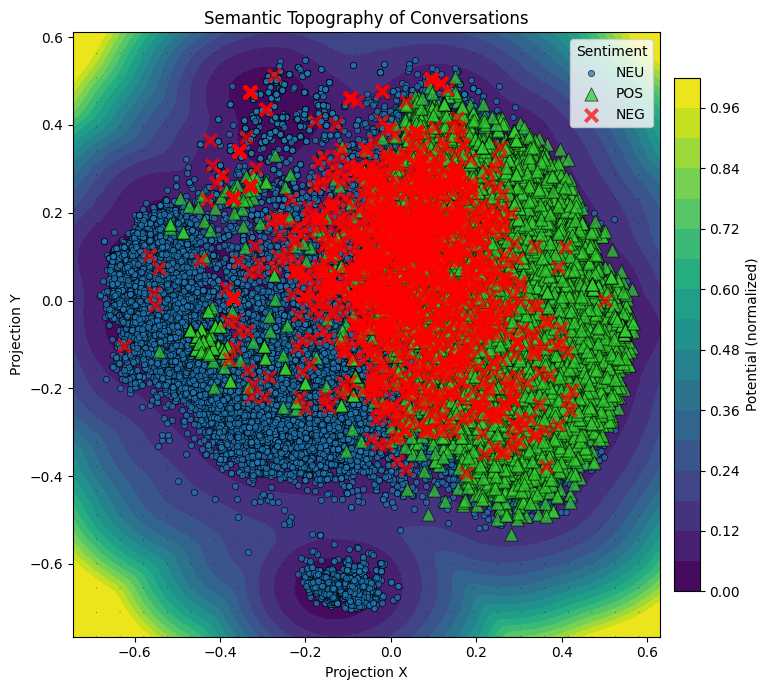

In [ ]:
# %% [code]
# 9) Visualize semantic topography with flow lines and (optional) sentiment coloring

import numpy as np
import matplotlib.pyplot as plt

# --- Preconditions ---
assert "proj_x" in msgs_df.columns and "proj_y" in msgs_df.columns, "Run Cell 7 first."
assert "potential_norm" in globals() or "potential" in globals(), "Run Cell 8 first."
assert "XX" in globals() and "YY" in globals(), "Run Cell 8 first."

# Choose which potential to plot
Z = potential_norm if "potential_norm" in globals() else potential

fig, ax = plt.subplots(figsize=(8, 7))

# --- Background topography (filled contours) ---
cf = ax.contourf(XX, YY, Z, levels=16)  # default colormap
cbar = fig.colorbar(cf, ax=ax, shrink=0.85, pad=0.02)
cbar.set_label("Potential (normalized)")

# --- Flow lines (downhill) from vector field ---
if "VX" in globals() and "VY" in globals():
    try:
        ax.streamplot(XX, YY, VX, VY, density=1.2, linewidth=0.7, arrowsize=0.8, color="k", alpha=0.4)
    except Exception as _e:
        # Fallback: sparse quiver if streamplot fails
        step = max(1, int(XX.shape[0] / 25))
        ax.quiver(XX[::step, ::step], YY[::step, ::step], VX[::step, ::step], VY[::step, ::step],
                  scale=50, width=0.002, alpha=0.5)

# --- Overlay points with custom style, ensuring NEG crosses are on top ---
px = msgs_df["proj_x"].to_numpy()
py = msgs_df["proj_y"].to_numpy()

if "sentiment_label" in msgs_df.columns:
    # sizes (pts^2) per label
    lbl_map = {"NEU": ("o", 20), "POS": ("^", 90), "NEG": ("x", 80)}

    # draw order: NEG last so it sits on top
    draw_order = ["NEU", "POS", "NEG"]

    for lbl in draw_order:
        mk, sz = lbl_map[lbl]
        sel = (msgs_df["sentiment_label"] == lbl) & np.isfinite(px) & np.isfinite(py)
        if not sel.any():
            continue

        # base kwargs shared by all
        kwargs = dict(s=sz, marker=mk, alpha=0.7, label=lbl)

        if lbl == "NEG":
            # crosses: thicker, red, higher z-order
            kwargs.update(dict(color="red", linewidths=2.8, zorder=5))
        elif lbl == "POS":
            # triangles: edge emphasized, medium z-order
            kwargs.update(dict(
                facecolors="limegreen",   # fill color
                edgecolors="k",           # border color
                linewidths=0.6,
                zorder=4
            ))
        else:  # NEU circles
            kwargs.update(dict(edgecolors="k", linewidths=0.6, zorder=3))

        ax.scatter(px[sel], py[sel], **kwargs)

    # legend
    ax.legend(title="Sentiment", loc="upper right", frameon=True)
else:
    # no sentiment: uniform dots
    mask = np.isfinite(px) & np.isfinite(py)
    ax.scatter(px[mask], py[mask], s=8, alpha=0.7, edgecolors="none")

ax.set_title("Semantic Topography of Conversations")
ax.set_xlabel("Projection X")
ax.set_ylabel("Projection Y")
ax.set_xlim(XX.min(), XX.max())
ax.set_ylim(YY.min(), YY.max())
ax.grid(False)
plt.tight_layout()
plt.show()


In [ ]:
# %% [code]
# 13) Choose conversations (shared sample) for overlay:
#     - 2 to 99 msgs
#     - >= 2 msgs with sentiment
#     - >= 1 non-neutral

import numpy as np
import pandas as pd

REQ = {"conversation_id", "message_index", "sentiment_score", "sentiment_label", "sentiment_num"}
assert REQ.issubset(msgs_df.columns), f"Missing columns: {REQ - set(msgs_df.columns)}"

conv_stats = msgs_df.groupby("conversation_id", as_index=False).agg(
    total_msgs=("message_index", "count"),
    msgs_with_sent=("sentiment_score", lambda s: s.notna().sum()),
    non_neu=("sentiment_num", lambda s: (s.fillna(0) != 0).sum())
)

eligible = conv_stats[
    (conv_stats["total_msgs"] >= 2) &
    (conv_stats["total_msgs"] < 10) &
    (conv_stats["msgs_with_sent"] >= 2) &
    (conv_stats["non_neu"] >= 1)
]["conversation_id"].tolist()

if not eligible:
    raise ValueError("No conversations matching: 2–99 msgs, >=2 with sentiment, >=1 non-neutral.")

N_SAMPLES = 20
rng = np.random.default_rng()
N = min(N_SAMPLES, len(eligible))
FOCUS_CIDS_OVERLAY = list(rng.choice(eligible, size=N, replace=False))

print(f"[Overlay] Using {len(FOCUS_CIDS_OVERLAY)} conversations (2–99 msgs, filtered).")

[Overlay] Using 20 conversations (2–99 msgs, filtered).


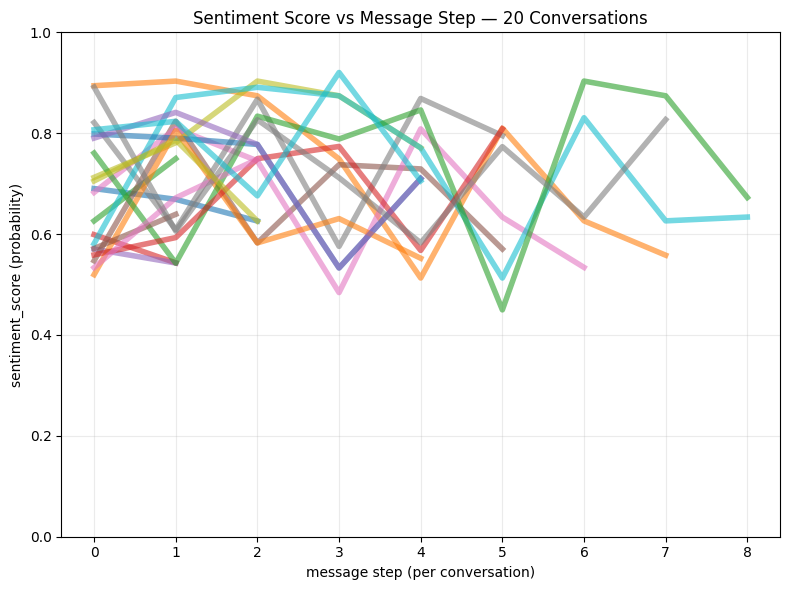

In [ ]:
# %% [code]
# 14) Sentiment score vs step index (per conversation) — combined

import numpy as np
import matplotlib.pyplot as plt

assert "FOCUS_CIDS_OVERLAY" in globals() and len(FOCUS_CIDS_OVERLAY) > 0, "Run Cell 13 first."

plt.figure(figsize=(8, 6))

for cid in FOCUS_CIDS_OVERLAY:
    g = (msgs_df.loc[msgs_df["conversation_id"] == cid]
         .sort_values("message_index")
         .dropna(subset=["sentiment_score"]))

    if len(g) < 2:
        continue

    # local step index: 0,1,2,... within this conversation
    step = np.arange(len(g))

    plt.plot(
        step,
        g["sentiment_score"].to_numpy(),
        linewidth=4,
        alpha=0.6
    )

plt.title(f"Sentiment Score vs Message Step — {len(FOCUS_CIDS_OVERLAY)} Conversations")
plt.xlabel("message step (per conversation)")
plt.ylabel("sentiment_score (probability)")
plt.ylim(0.0, 1.0)
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()

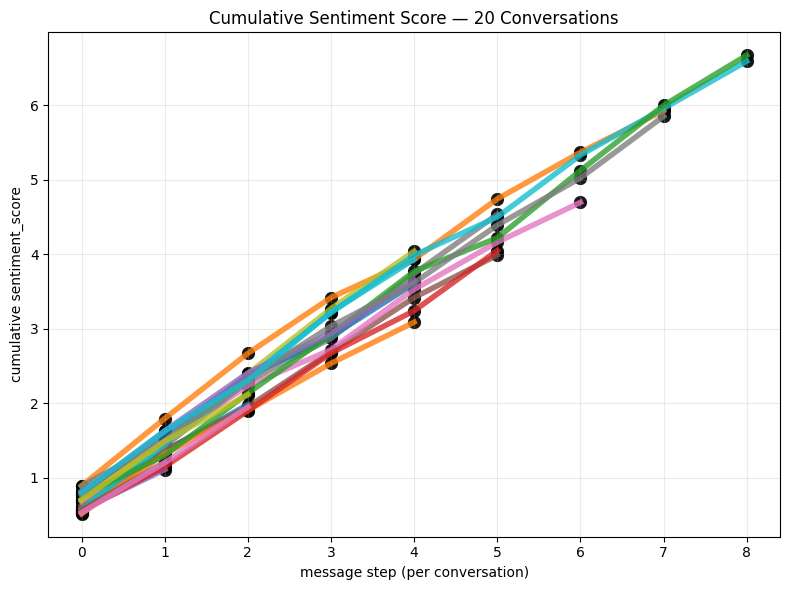

In [ ]:
# %% [code]
# 15) Cumulative sentiment_score for the SAME selected conversations
#     (no signs, no zeros injected, just sum of the plotted scores)
#     + dots at each message step

import numpy as np
import matplotlib.pyplot as plt

assert "FOCUS_CIDS_OVERLAY" in globals() and len(FOCUS_CIDS_OVERLAY) > 0, "Run Cell 13 first."

plt.figure(figsize=(8, 6))

shown = 0

for cid in FOCUS_CIDS_OVERLAY:
    # Same filtering logic as in the sentiment curve plot
    g = (
        msgs_df.loc[msgs_df["conversation_id"] == cid]
        .sort_values("message_index")
        .dropna(subset=["sentiment_score"])
    )

    if len(g) < 2:
        continue

    # Use EXACTLY the same scores as in the previous plot
    scores = g["sentiment_score"].to_numpy()

    # Cumulative sum of those scores
    csum = np.cumsum(scores)

    # Local step index for this conversation (0..len-1)
    step = np.arange(len(csum))

    # Line
    plt.plot(
        step,
        csum,
        linewidth=4,
        alpha=0.8
    )

    # Dots on top of the line
    plt.scatter(
        step,
        csum,
        s=30,
        alpha=0.9,
        edgecolors="k",
        linewidths=4
    )

    shown += 1

plt.title(f"Cumulative Sentiment Score — {shown} Conversations")
plt.xlabel("message step (per conversation)")
plt.ylabel("cumulative sentiment_score")
# plt.yscale("log")   # uncomment if you want log later
# plt.xscale("log")   # idem for x
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()

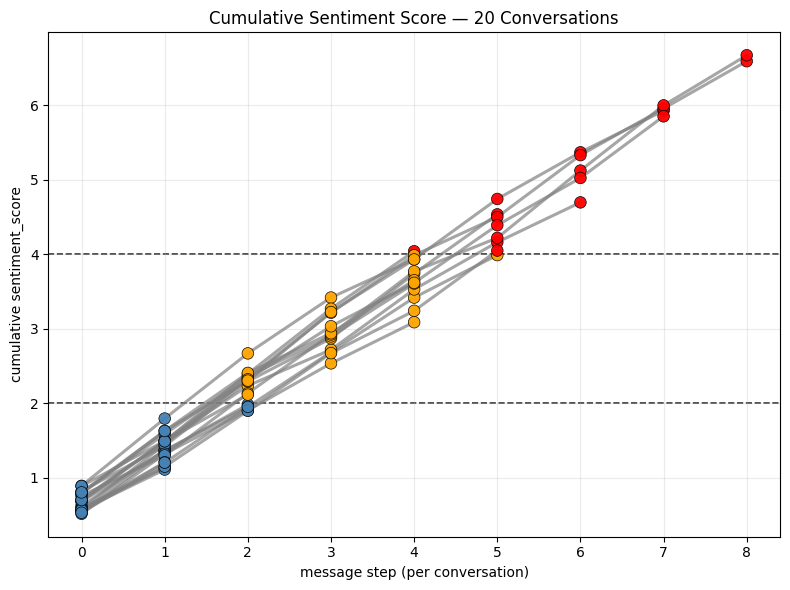

In [ ]:
# %% [code]
# 15) Cumulative sentiment_score for the SAME selected conversations
#     + dots at each message step
#     + horizontal lines at y=2 and y=4
#     + dot color based on cumulative "temperature" bucket

import numpy as np
import matplotlib.pyplot as plt

assert "FOCUS_CIDS_OVERLAY" in globals() and len(FOCUS_CIDS_OVERLAY) > 0, "Run Cell 13 first."

fig, ax = plt.subplots(figsize=(8, 6))

shown = 0

for cid in FOCUS_CIDS_OVERLAY:
    g = (
        msgs_df.loc[msgs_df["conversation_id"] == cid]
        .sort_values("message_index")
        .dropna(subset=["sentiment_score"])
    )
    if len(g) < 2:
        continue

    scores = g["sentiment_score"].to_numpy()
    csum = np.cumsum(scores)
    step = np.arange(len(csum))

    # Base line for this conversation
    ax.plot(
        step,
        csum,
        linewidth=2.2,
        alpha=0.7,
        color="gray",
        zorder=2
    )

    # Color dots by cumulative "zone"
    # <2 = cold, 2-4 = warm, >4 = hot
    colors = []
    for v in csum:
        if v < 2:
            colors.append("steelblue")   # cold
        elif v < 4:
            colors.append("orange")      # warm
        else:
            colors.append("red")         # hot

    # Dots above lines and guide lines
    ax.scatter(
        step,
        csum,
        s=70,
        c=colors,
        alpha=0.95,
        edgecolors="k",
        linewidths=0.5,
        zorder=4
    )

    shown += 1

# Horizontal guide lines (under dots)
ax.axhline(y=2, color="black", linestyle="--", linewidth=1.2, alpha=0.8, zorder=1.5)
ax.axhline(y=4, color="black", linestyle="--", linewidth=1.2, alpha=0.8, zorder=1.5)

ax.set_title(f"Cumulative Sentiment Score — {shown} Conversations")
ax.set_xlabel("message step (per conversation)")
ax.set_ylabel("cumulative sentiment_score")
ax.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()


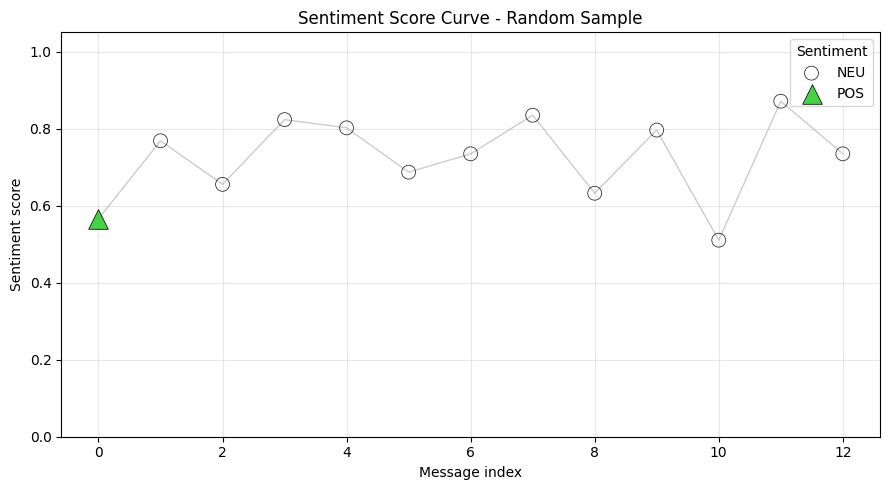

In [ ]:
# %% [code]
# Plot a random conversation's sentiment score curve
# Using the SAME symbols/colors as the semantic surface plot:
# NEG = red "x", POS = limegreen "^", NEU = black-edged "o"

import numpy as np
import matplotlib.pyplot as plt
import random

assert "msgs_df" in globals(), "msgs_df not found — make sure dataset is loaded."
assert "sentiment_score" in msgs_df.columns, "Expected 'sentiment_score' column in msgs_df."
assert "sentiment_label" in msgs_df.columns, "Expected 'sentiment_label' column in msgs_df."
assert "conversation_id" in msgs_df.columns, "Expected 'conversation_id' column in msgs_df."

# --- Pick a random conversation with >1 message having sentiment ---
valid_convos = (
    msgs_df.dropna(subset=["sentiment_score"])
           .groupby("conversation_id")["message_index"]
           .count()
)
valid_convos = valid_convos[valid_convos > 1].index.tolist()
assert len(valid_convos) > 0, "No multi-message conversations with sentiment found."

cid = random.choice(valid_convos)

g = (
    msgs_df.loc[msgs_df["conversation_id"] == cid]
    .sort_values("message_index")
    .dropna(subset=["sentiment_score", "sentiment_label"])
)

steps = np.arange(len(g))
scores = g["sentiment_score"].to_numpy()
labels = g["sentiment_label"].to_numpy()

fig, ax = plt.subplots(figsize=(9, 5))

# Thin neutral line connecting points (for shape)
ax.plot(steps, scores, color="gray", linewidth=1.0, alpha=0.4, zorder=1)

# Styles matching Cell 9
style_map = {
    "NEG": dict(marker="x", s=200, color="red",            linewidths=2.8, alpha=0.9, zorder=5),
    "POS": dict(marker="^", s=200, facecolors="limegreen", edgecolors="k", linewidths=0.6, alpha=0.9, zorder=4),
    "NEU": dict(marker="o", s=100, facecolors="none",      edgecolors="k", linewidths=0.6, alpha=0.8, zorder=3),
}

handles = []

# Plot each sentiment with its correct symbol/color
for lbl in ["NEU", "POS", "NEG"]:  # order so NEG is drawn last (on top)
    sel = labels == lbl
    if not np.any(sel):
        continue

    h = ax.scatter(
        steps[sel],
        scores[sel],
        label=lbl,
        **style_map[lbl],
    )
    handles.append(h)

ax.set_title(f"Sentiment Score Curve - Random Sample")
ax.set_xlabel("Message index")
ax.set_ylabel("Sentiment score")
ax.set_ylim(0, 1.05)
ax.grid(True, alpha=0.3)

if handles:
    ax.legend(handles=handles, title="Sentiment", loc="upper right", frameon=True)

plt.tight_layout()
plt.show()

Plotting conversation 64aef374-65e1-4e99-a799-44c4d4866706 with 5 messages


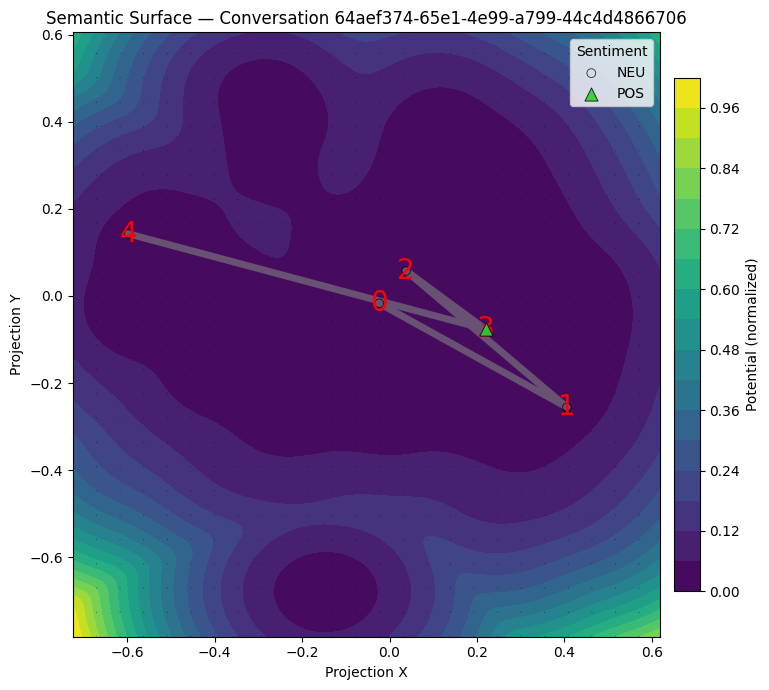

In [ ]:
# %% [code]
# 16) Plot semantic surface for one random conversation (with message positions)

import numpy as np
import matplotlib.pyplot as plt
import random

# --- Preconditions ---
assert all(col in msgs_df.columns for col in ["proj_x", "proj_y", "conversation_id", "sentiment_label"]), \
    "Expected proj_x, proj_y, conversation_id, sentiment_label in msgs_df."
assert "potential_norm" in globals() or "potential" in globals(), "Run Cell 8 first (potential surface)."
assert "XX" in globals() and "YY" in globals(), "Run Cell 8 first (grid variables)."

# Choose which potential field to use
Z = potential_norm if "potential_norm" in globals() else potential

# --- Select one random conversation with enough messages ---
valid_convos = msgs_df["conversation_id"].value_counts()
valid_convos = valid_convos[valid_convos > 1].index.tolist()
assert len(valid_convos) > 0, "No multi-message conversations found."

cid = random.choice(valid_convos)
conv = msgs_df[msgs_df["conversation_id"] == cid].dropna(subset=["proj_x", "proj_y"])

print(f"Plotting conversation {cid} with {len(conv)} messages")

# --- Base plot: potential surface ---
fig, ax = plt.subplots(figsize=(8, 7))
cf = ax.contourf(XX, YY, Z, levels=16)
fig.colorbar(cf, ax=ax, shrink=0.85, pad=0.02, label="Potential (normalized)")

# --- Draw flow lines if available ---
if "VX" in globals() and "VY" in globals():
    try:
        ax.streamplot(XX, YY, VX, VY, density=1.2, linewidth=0.7, arrowsize=0.8, color="k", alpha=0.4)
    except Exception:
        step = max(1, int(XX.shape[0] / 25))
        ax.quiver(XX[::step, ::step], YY[::step, ::step], VX[::step, ::step], VY[::step, ::step],
                  scale=50, width=0.002, alpha=0.5)

# --- Overlay only messages from this conversation ---
px = conv["proj_x"].to_numpy()
py = conv["proj_y"].to_numpy()
labels = conv["sentiment_label"].to_numpy()

# Matching Cell 9 styling
style_map = {
    "NEG": dict(marker="x", s=80, color="red",            linewidths=2.8, alpha=0.9, zorder=5),
    "POS": dict(marker="^", s=90, facecolors="limegreen", edgecolors="k", linewidths=0.6, alpha=0.9, zorder=4),
    "NEU": dict(marker="o", s=40, facecolors="none",      edgecolors="k", linewidths=0.6, alpha=0.8, zorder=3),
}

# Plot each label category
for lbl in ["NEU", "POS", "NEG"]:
    sel = labels == lbl
    if not np.any(sel):
        continue
    ax.scatter(px[sel], py[sel], **style_map[lbl], label=lbl)

# --- Connect conversation messages sequentially ---
ax.plot(px, py, color="gray", linewidth=5, alpha=0.6, zorder=2)

# Annotate message index
for i, (x, y) in enumerate(zip(px, py)):
    ax.text(x, y, str(i), fontsize=20, ha="center", va="center", color="red")

ax.set_title(f"Semantic Surface — Conversation {cid}")
ax.set_xlabel("Projection X")
ax.set_ylabel("Projection Y")
ax.legend(title="Sentiment", loc="upper right", frameon=True)
ax.grid(False)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


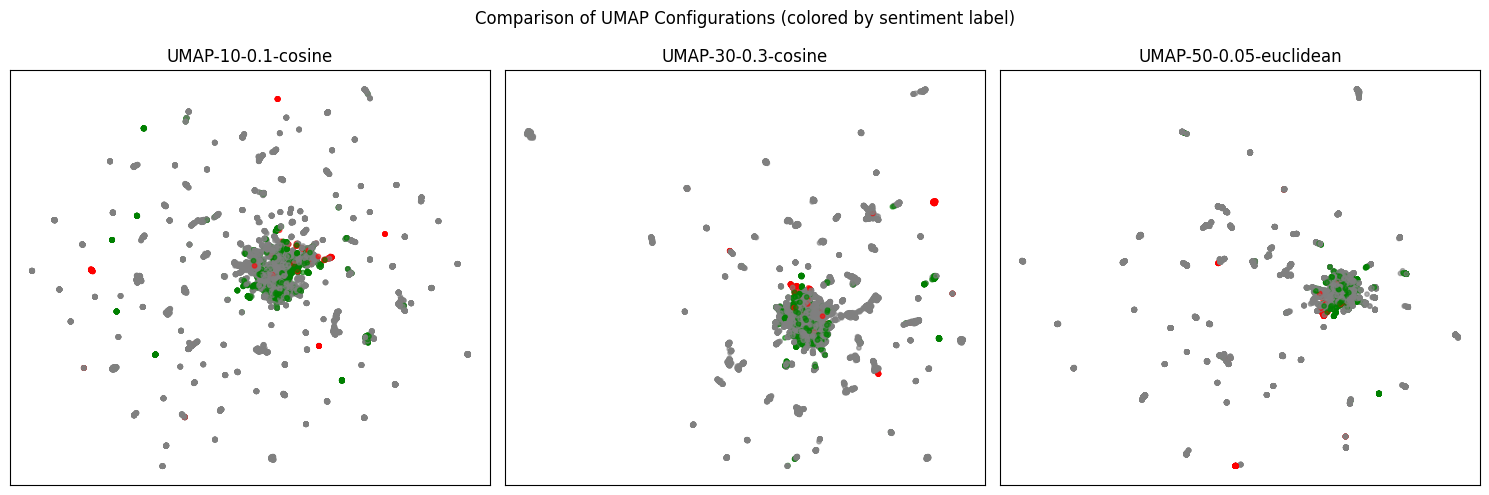

In [ ]:
# %% [code]
# 11) Compare multiple UMAP configurations side by side

import matplotlib.pyplot as plt
import umap
import numpy as np
import pandas as pd

assert "embedding" in msgs_df.columns, "Run the cell that generates embeddings first."

# ---- Configurations to compare ----
umap_configs = [
    {"n_neighbors": 10, "min_dist": 0.1, "metric": "cosine", "label": "UMAP-10-0.1-cosine"},
    {"n_neighbors": 30, "min_dist": 0.3, "metric": "cosine", "label": "UMAP-30-0.3-cosine"},
    {"n_neighbors": 50, "min_dist": 0.05, "metric": "euclidean", "label": "UMAP-50-0.05-euclidean"},
]

# Prepare data
X = np.vstack(msgs_df["embedding"].values)
has_sent = msgs_df["sentiment_label"].notna()
colors = msgs_df.loc[has_sent, "sentiment_label"].map({"NEG": "red", "NEU": "gray", "POS": "green"}).fillna("black")

# ---- Compute each UMAP and plot ----
n_cols = len(umap_configs)
fig, axes = plt.subplots(1, n_cols, figsize=(5 * n_cols, 5))

for ax, cfg in zip(axes, umap_configs):
    reducer = umap.UMAP(
        n_neighbors=cfg["n_neighbors"],
        min_dist=cfg["min_dist"],
        metric=cfg["metric"],
        random_state=42
    )
    proj = reducer.fit_transform(X)
    ax.scatter(proj[:, 0], proj[:, 1], s=10, c=colors, alpha=0.6)
    ax.set_title(cfg["label"])
    ax.set_xticks([]); ax.set_yticks([])

plt.suptitle("Comparison of UMAP Configurations (colored by sentiment label)")
plt.tight_layout()
plt.show()


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


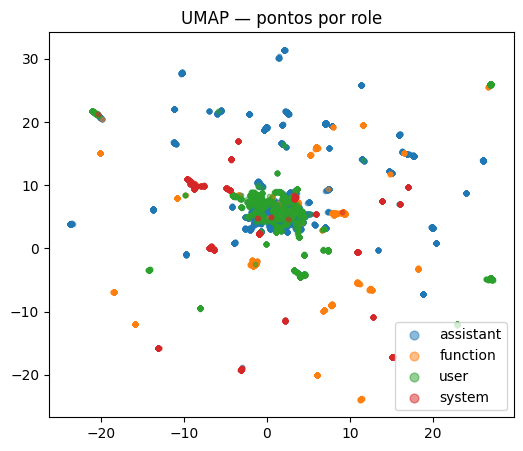

In [ ]:
# %% [code]
# 6) Projeção 2D (PCA por padrão; UMAP se disponível e PROJ_BASE == "umap")
from sklearn.decomposition import PCA

PROJ_BASE = "umap"   # "pca" ou "umap"
X_embed = preds_df[[c for c in preds_df.columns if c.startswith("emb_")]].values

proj_name = "PCA"
try:
    if PROJ_BASE.lower() == "umap":
        import umap
        reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, metric="cosine", random_state=42)
        proj = reducer.fit_transform(X_embed)
        proj_name = "UMAP"
    else:
        raise ImportError("Forçando PCA")
except Exception:
    pca = PCA(n_components=2, random_state=42)
    proj = pca.fit_transform(X_embed)
    if 'pca' in locals():
        print("Explained variance (PCA):", np.round(pca.explained_variance_ratio_, 4))

proj_df = preds_df.copy()
proj_df["proj_x"] = proj[:,0]
proj_df["proj_y"] = proj[:,1]

fig, ax = plt.subplots(figsize=(6,5))
for r in proj_df["role"].unique():
    sub = proj_df[proj_df["role"]==r]
    ax.scatter(sub["proj_x"], sub["proj_y"], s=10, alpha=0.5, label=r)
ax.set_title(f"{proj_name} — pontos por role")
ax.legend(markerscale=2)
plt.show()


Aviso: streamplot não pôde ser gerado ('x' values must be equally spaced). Exibindo apenas contornos.


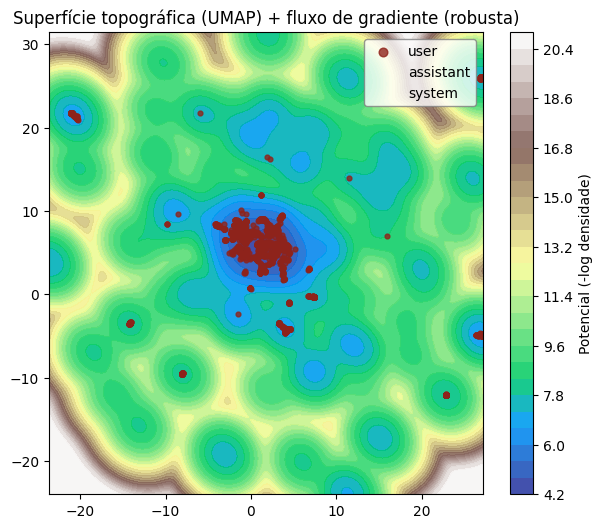

In [ ]:
# %% [code]
# 7) Superfície topográfica robusta (potencial = -log densidade) + fluxo de gradiente
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import numpy as np

GRID_N = 200
BW = 0.18
EPS = 1e-9

proj_data = proj_df.dropna(subset=["proj_x","proj_y"]).copy()
x = proj_data["proj_x"].values
y = proj_data["proj_y"].values

if len(proj_data) < 50:
    print("Poucos pontos projetados; considere aumentar o dataset ou reduzir GRID_N.")

# Evitar ranges degenerados
x_min, x_max = np.min(x), np.max(x)
y_min, y_max = np.min(y), np.max(y)
if np.isclose(x_min, x_max):
    x_max = x_min + 1e-3
if np.isclose(y_min, y_max):
    y_max = y_min + 1e-3

# Eixos uniformes com precisão controlada
x1d = np.round(np.linspace(x_min, x_max, GRID_N), 6)
y1d = np.round(np.linspace(y_min, y_max, GRID_N), 6)
dx = (x1d[-1] - x1d[0]) / (GRID_N - 1)
dy = (y1d[-1] - y1d[0]) / (GRID_N - 1)

xx, yy = np.meshgrid(x1d, y1d, indexing='xy')

# KDE 2D
kde = gaussian_kde(np.vstack([x, y]), bw_method=BW)
dens = kde(np.vstack([xx.ravel(), yy.ravel()])).reshape(xx.shape)

# Potencial e gradiente
E = -np.log(dens + EPS)
dE_dy, dE_dx = np.gradient(E, dy, dx)  # Ny x Nx

U, V = -dE_dx, -dE_dy  # fluxo de descida

fig, ax = plt.subplots(figsize=(7,6))
cs = ax.contourf(xx, yy, E, levels=30, cmap="terrain", alpha=0.9)
plt.colorbar(cs, ax=ax, label="Potencial (-log densidade)")

try:
    ax.streamplot(x1d, y1d, U, V, color="k", density=1.1, linewidth=0.7, arrowsize=0.7)
except ValueError as e:
    print(f"Aviso: streamplot não pôde ser gerado ({e}). Exibindo apenas contornos.")

# Paleta personalizada por papel (role)
role_colors = {
    "user": "#8f231b",       # vermelho suave
    "assistant": "#d9f507",  # azul
    "system": "#9607f5",     # roxo
    "other": "#95a5a6"       # cinza
}

# Pontos por role com cores definidas
for r in ["user", "assistant", "system", "other"]:
    s = proj_df[proj_df["role"] == r]
    if not s.empty:
        ax.scatter(
            s["proj_x"], s["proj_y"],
            s=12,
            alpha=0.8 if r == "user" else 0.0008,
            color=role_colors.get(r, "#7f8c8d"),  # fallback caso apareça algo fora da lista
            label=r
        )

ax.set_title(f"Superfície topográfica ({proj_name}) + fluxo de gradiente (robusta)")
ax.legend(markerscale=1.8, frameon=True, facecolor="white", edgecolor="gray")
plt.show()


/tmp/ipython-input-1037855049.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=8, ncol=2)


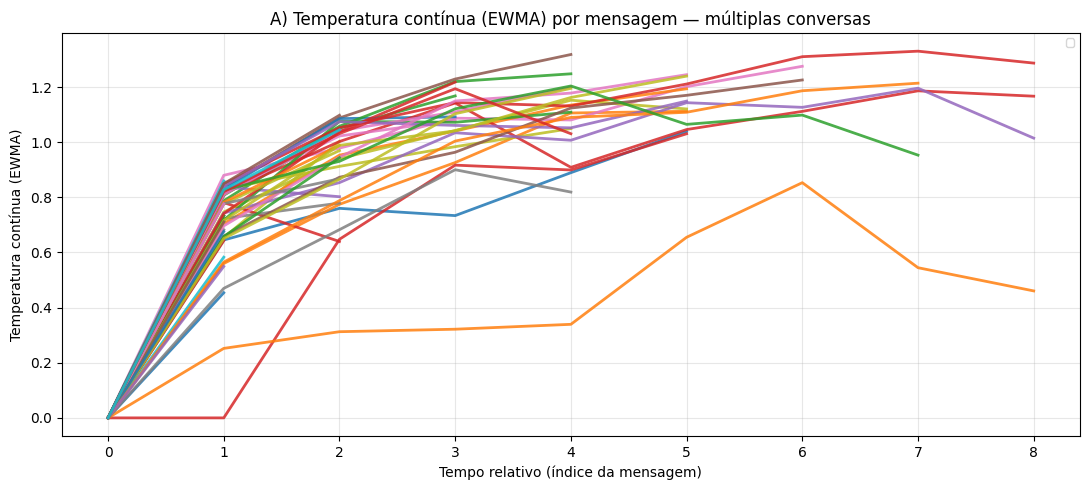

/tmp/ipython-input-1037855049.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=8, ncol=2)


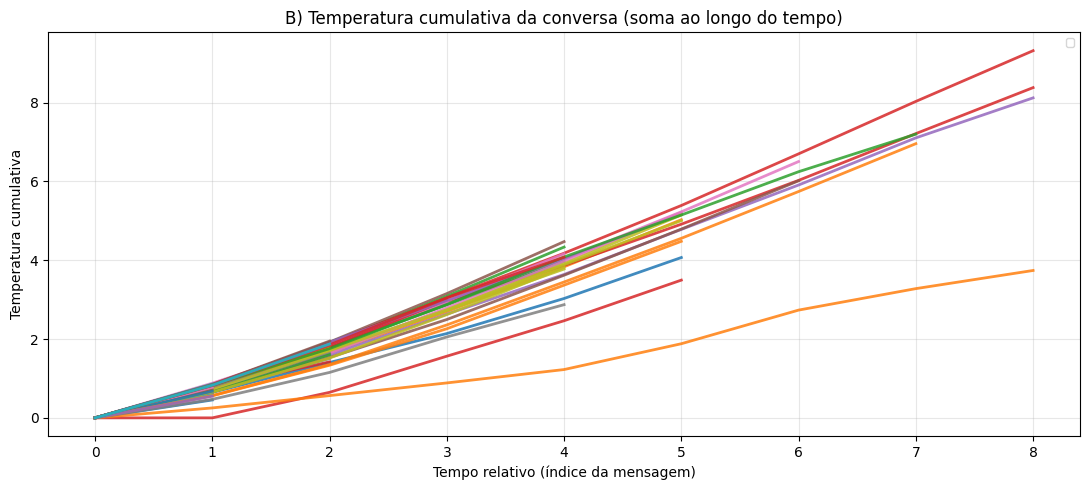

In [ ]:
# %% [code]
import matplotlib.pyplot as plt
import numpy as np

N_CONV = 100

def detect_ewma_column(df: pd.DataFrame):
    """
    Detecta automaticamente a coluna EWMA disponível.
    """
    candidates = [c for c in df.columns if "ewma" in c.lower()]
    if not candidates:
        print("⚠️ Nenhuma coluna EWMA encontrada — será gerada a partir de 'temperature' ou 'temp_num'.")
        # cria coluna numérica básica e aplica EWMA por conversa
        if "temp_num" not in df.columns:
            TEMP_MAP = {"COLD": -1, "WARM": 0, "HOT": 1}
            df["temp_num"] = df["temperature"].map(TEMP_MAP).fillna(0)
        df = compute_ewma(df, col_num="temp_num", alpha=0.35)
        candidates = [c for c in df.columns if "ewma" in c.lower()]
    return df, candidates[0]

def plot_conversation_temperatures(df: pd.DataFrame, conv_ids, value_col=None):
    """
    Plota duas curvas:
      A) temperatura contínua (EWMA)
      B) soma cumulativa da temperatura
    """
    df, value_col = detect_ewma_column(df) if value_col is None else (df, value_col)

    plt.figure(figsize=(11,5))
    for cid in conv_ids:
        g = df[df["conversation_id"] == cid].sort_values("message_index")
        if g.empty: continue
        x = np.arange(len(g))
        y = g[value_col].astype(float).fillna(0).values
        plt.plot(x, y, lw=2, alpha=0.85)#, label=f"{cid[:8]}")
    plt.title("A) Temperatura contínua (EWMA) por mensagem — múltiplas conversas")
    plt.xlabel("Tempo relativo (índice da mensagem)")
    plt.ylabel("Temperatura contínua (EWMA)")
    plt.grid(alpha=0.3)
    if len(conv_ids) <= N_CONV:
        plt.legend(fontsize=8, ncol=2)
    plt.tight_layout()
    plt.show()

    # Gráfico B: soma cumulativa
    plt.figure(figsize=(11,5))
    for cid in conv_ids:
        g = df[df["conversation_id"] == cid].sort_values("message_index")
        if g.empty: continue
        x = np.arange(len(g))
        ycum = np.cumsum(g[value_col].astype(float).fillna(0).values)
        plt.plot(x, ycum, lw=2, alpha=0.85)#, label=f"{cid[:8]}")
    plt.title("B) Temperatura cumulativa da conversa (soma ao longo do tempo)")
    plt.xlabel("Tempo relativo (índice da mensagem)")
    plt.ylabel("Temperatura cumulativa")
    plt.grid(alpha=0.3)
    if len(conv_ids) <= N_CONV:
        plt.legend(fontsize=8, ncol=2)
    plt.tight_layout()
    plt.show()

# Rodar
plot_conversation_temperatures(preds_df, sel_convs)
